# MNIST subset with vanilla network

I get about what a RF gets with 10k subsample of 60k images.

**colab** github can't seem to display notebooks so...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/mnist/notebooks/mnist-vanilla.ipynb)


## Setup
Make sure to enable this to see progress bars:

```
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [1]:
!pip install -q --no-deps tensorflow-addons~=0.7
!pip install -q "tqdm>=4.36.1"

## MNIST Images

In [1]:
import tensorflow as tf
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
sub = 10_000
X_train = X_train[:sub,:,:]
X_test = X_test[:sub,:,:]
y_train = y_train[:sub]
y_test = y_test[:sub]

n, w, h = X_train.shape

print(f"Using {n} images")

Using TensorFlow backend.


Using 10000 images


## RandomForestClassifier

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [11]:
rf = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=1,
                            oob_score=True, n_jobs=-1)
rf.fit(X_train.reshape(n,-1), y_train)
print(rf.oob_score_)

y_pred = rf.predict(X_test.reshape(n, -1))
conf = confusion_matrix(y_test, y_pred)
print(conf)
print("test accuracy", accuracy_score(y_test, y_pred))

0.9424
[[ 968    1    1    0    0    1    5    1    3    0]
 [   0 1121    2    4    0    1    4    1    2    0]
 [   5    1  978   10    7    1    7   13    8    2]
 [   3    0   18  944    0   15    0   12   12    6]
 [   1    2    4    1  927    0   10    0    4   33]
 [   9    1    3   17    4  833    7    3    9    6]
 [  11    3    2    0   11    5  924    0    2    0]
 [   2   12   31    3    1    0    0  967    4    8]
 [   5    1    6   14    9    7   10    2  901   19]
 [   6    7    2   15   17    4    3    6    8  941]]
test accuracy 0.9504


Conclusion is that a RF with only 100 trees does a quick easy job on this 10k image subsample. Does about what DL does with vanilla net, but accuracy .95 and .963 are very far apart if you're trying to win a competition.

## Vanilla two-layers of 512 neurons, softmax on end

In [4]:
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback

### Don't forget to normalize data for DL

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [12]:
num_classes = 10
layer1 = 512
layer2 = 512
batch_size = 2500
dropout = 0.2

model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=w*h, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(layer2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(num_classes, activation='softmax'))

In [7]:
learning_rate = 0.15
# opt = optimizers.Adam(lr=learning_rate)
opt = optimizers.RMSprop() # this one seems a bit better

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

# callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train.reshape(n,w*h), y_train,
                    epochs=150,
                    validation_data=(X_test.reshape(n,w*h), y_test),
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

In [8]:
y_pred = model.predict(X_test.reshape(n,w*h))
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y_test, y_pred)
print("Keras validation accuracy", val_accur)

conf = confusion_matrix(y_test, y_pred)
print(conf)

Keras validation accuracy 0.9635
[[ 961    0    0    0    2    0    9    3    5    0]
 [   0 1126    2    1    0    1    4    1    0    0]
 [   7    2  982    7    5    0    5   11   12    1]
 [   0    0    9  979    1    4    0    8    8    1]
 [   0    1    0    0  965    0    7    1    1    7]
 [   6    0    0   15    5  838   10    2   12    4]
 [   5    3    1    0   13    4  925    1    6    0]
 [   0    6   12    1    7    2    0  991    3    6]
 [   7    0    1    5   12    2    2    9  931    5]
 [   3    4    1    8   31    1    2   16    6  937]]


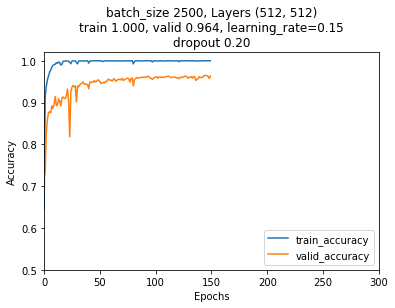

In [9]:
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
plt.title(f"batch_size {batch_size}, Layers {layer1,layer2}\ntrain {accur[-1]:.3f}, valid {val_accur[-1]:.3f}, learning_rate={learning_rate:.2f}\ndropout {dropout:.2f}")
plt.xlim(0, 300)
plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()